# **PointNet Demo**
This code is the implementation of [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/pdf/1612.00593.pdf). We demonstrate the applications of point cloud classification
.

# Getting started

In [ ]:
import numpy as np
import math
import random
import os
import torch
from glob import glob
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import plotly.graph_objects as go

In [ ]:
!pip install path.py;
!pip install trimesh
from path import Path
import trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 646 kB 5.0 MB/s 


In [ ]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2022-05-24 07:51:46--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.61
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.61|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  71.4MB/s    in 6.4s    

2022-05-24 07:51:52 (70.7 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [ ]:
!unzip -q ModelNet10.zip;

In [ ]:
classes = ['ceiling', 'floor', 'wall', 'beam', 'column', 'window', 'door', 'table', 'chair', 'sofa', 'bookcase',
           'board', 'clutter']
class2label = {cls: i for i, cls in enumerate(classes)}
seg_classes = class2label
seg_label_to_cat = {}
for i, cat in enumerate(seg_classes.keys()):
    seg_label_to_cat[i] = cat

In [ ]:
NUM_CLASSES = 13
BATCH_SIZE = 32
NUM_POINT = 4096  ## What is its use? 

In [ ]:
path = Path("ModelNet10")

In [ ]:
path

Path('ModelNet10')

In [ ]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

# Visualizing mesh

In [ ]:
pcd = trimesh.load("ModelNet10/sofa/train/sofa_0001.off")

In [ ]:
scene = trimesh.scene.Scene()
scene.add_geometry(pcd)
scene.show()

In [ ]:
#load vertices and faces from mesh
verts = pcd.vertices
faces = pcd.faces

In [ ]:
p = trimesh.points.PointCloud(verts, colors=np.tile(np.array([0, 0, 0, 1]), (len(verts), 1)))

In [ ]:
scene = trimesh.scene.Scene()
scene.add_geometry(p)
scene.show()

# Data pre-processing

## Sample Points

In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, mesh):
        sampled_pc = trimesh.sample.sample_surface(mesh,self.output_size)
        pc = sampled_pc[0]
        return pc

In [ ]:
pc = PointSampler(3000)(pcd)
p = trimesh.points.PointCloud(pc, colors=np.tile(np.array([0, 0, 0, 1]), (len(pc), 1)))

scene = trimesh.scene.Scene()
scene.add_geometry(p)
scene.show()

## Normalize

We need to position the point cloud at the center (0,0,0) and the values normalized between 0-1.

In [ ]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [ ]:
norm_pointcloud = Normalize()(pc)

## Data Augmentations

We randomly rotate the point cloud and add random noice. 

In [ ]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [ ]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [ ]:
p = trimesh.points.PointCloud(noisy_rot_pointcloud, colors=np.tile(np.array([0, 0, 0, 1]), (len(noisy_rot_pointcloud), 1)))

scene = trimesh.scene.Scene()
scene.add_geometry(p)
scene.show()

## To Tensor

In [ ]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

# Dataset

In [ ]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)
 
    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        pcd = trimesh.load(file)
        verts = pcd.vertices
        faces = pcd.faces

        if self.transforms:
            pointcloud = self.transforms((pcd))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        
        pointcloud = self.__preproc__(pcd_path)
        
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [ ]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [ ]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [ ]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [ ]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [ ]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True,drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64,drop_last=True)

# Model
Pointnet classification architecture. 
![PointNet.png](https://drive.google.com/uc?id=1jHrqnK5lsx2Sn0CeMrhB4k8fbDOYk_ue)


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

# Loss
![PointNet_loss.png](https://drive.google.com/uc?id=1CeBXu_o9Wdtweqa9QbjRlamyU9GHG9Go)


where A is the feature alignment matrix predicted by the transformer network.

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
pointnet = PointNet()
pointnet.to(device);  ## Question: Why does this step take some time, the first time? 

In [ ]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [ ]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "save_"+str(epoch)+".pth")

In [ ]:
train(pointnet, train_loader, valid_loader, 1, save=True) # 1-epoch #time: 
# Question for audience, where did "/124" come from? 

[Epoch: 1, Batch:   10 /  124], loss: 1.997
[Epoch: 1, Batch:   20 /  124], loss: 1.553
[Epoch: 1, Batch:   30 /  124], loss: 1.462
[Epoch: 1, Batch:   40 /  124], loss: 1.378
[Epoch: 1, Batch:   50 /  124], loss: 1.108
[Epoch: 1, Batch:   60 /  124], loss: 0.946
[Epoch: 1, Batch:   70 /  124], loss: 1.106
[Epoch: 1, Batch:   80 /  124], loss: 1.010
[Epoch: 1, Batch:   90 /  124], loss: 1.023
[Epoch: 1, Batch:  100 /  124], loss: 0.916
[Epoch: 1, Batch:  110 /  124], loss: 0.859
[Epoch: 1, Batch:  120 /  124], loss: 0.883
Valid accuracy: 61 %


# Test

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
!gdown --id 182FvuCfh1z_H3kBInXiX2wgy-ypRULkK

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=182FvuCfh1z_H3kBInXiX2wgy-ypRULkK
To: /content/pointnet_cls.pth
100% 13.9M/13.9M [00:00<00:00, 183MB/s]


In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('pointnet_cls.pth',map_location=torch.device('cpu')))
pointnet.eval();

In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())
        


Batch [   1 /   14]
Batch [   2 /   14]
Batch [   3 /   14]
Batch [   4 /   14]
Batch [   5 /   14]
Batch [   6 /   14]
Batch [   7 /   14]
Batch [   8 /   14]
Batch [   9 /   14]
Batch [  10 /   14]
Batch [  11 /   14]
Batch [  12 /   14]
Batch [  13 /   14]
Batch [  14 /   14]


In [ ]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[ 41,   9,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  97,   2,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   2,  35,   5,   0,  18,   4,  20,   1],
       [  0,   0,   0,   0,  45,   0,  40,   0,   1,   0],
       [  0,   0,   1,   0,  24,  73,   2,   0,   0,   0],
       [  0,   0,   1,   0,   6,   0,  78,   0,   1,   0],
       [  0,   1,   1,   0,   1,   0,   1,  96,   0,   0],
       [  0,   0,   0,   5,   0,   0,   1,   0,  94,   0],
       [  1,   0,  12,   0,   1,   0,   2,   1,   1,  70]])

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


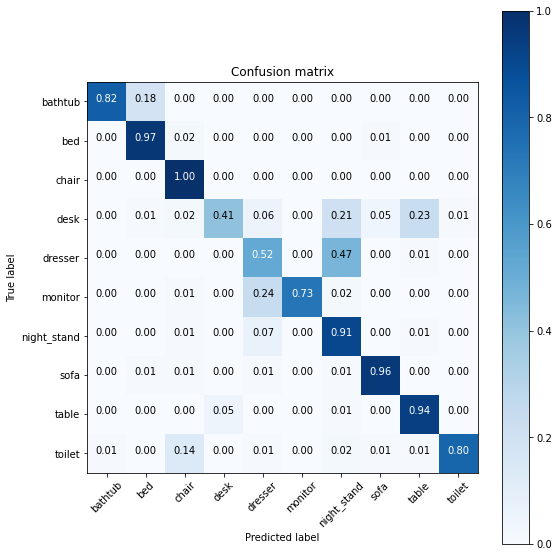

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


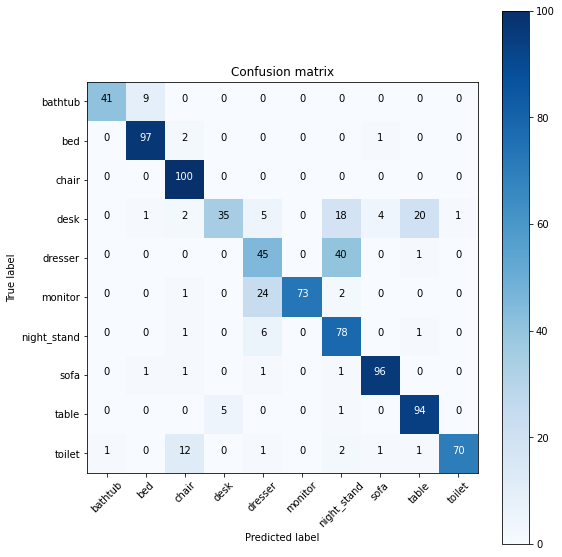

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)